# Multi-Touch Attribution Models
Multi-touch models assume that all touchpoints play some role in driving a conversion. We look at the most popular multi-touch attribution models which include Linear, Position decay, and U-shaped models. These models have become important for marketers, particularly those looking to measure the impact of digital campaigns, since they provide a more granular and person-level view than traditional aggregation methods. These models should be used when the number of channels for a campaign is 5 to 10, the most preferable of which are position-based, like the U-shaped Attribution Model.

## Import Dependencies and Load Data

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None
sns.set_palette('summer')

In [2]:
df = pd.read_csv('data/attribution_data.csv')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


## Linear Attribution Model
The Linear Attribution Model gives each touchpoint across the buyer journey the same amount of credit toward driving a sale; it values every touchpoint evenly. This model is easy to implement and is better than all the single-touch attribution models. The *disadvantage* here is that in reality, consumers aren't equally impacted by every kind of channel.

In [3]:
def linear_model(df, conv_col, channel_col, user_id):
    """
    Build a Linear Multi-Touch Attribution Model
    """
    # Keep data of only those users who are getting converted
    tmp = df[df[conv_col] == 1]
    cookie_index = list(tmp[user_id])
    df['new'] = df[user_id].isin(cookie_index)
    y = df['new'].isin([True])
    df_conv = df[y]
    tmp = pd.DataFrame(df_conv.groupby(user_id).tail(1))
    
    # Get total amount of channels visited by user
    x = Counter(df_conv[user_id])
    tmp['user_click_count'] = x.values()
    tmp.set_index(user_id, inplace=True)
    df_conv['clicks'] = df_conv[user_id].map(x)
    
    # Assign weights
    df_conv = df_conv.assign(clicks_per=lambda x: round(
        100 / df_conv['clicks'], 2))
    
    # Get the mean weight of every channel
    res_linear = df_conv.groupby(
        channel_col, as_index=False)['clicks_per'].mean()
    _sum = res_linear['clicks_per'].sum()
    
    # Get as a percentage
    res_linear['Weight (%)'] = res_linear.apply(lambda x: round(
        (x['clicks_per'] / _sum) * 100, 2), axis=1)
    res_linear.drop(['clicks_per'], inplace=True, axis=1)
    res_linear = res_linear.set_index(channel_col)
    res_linear.index.name = None
    return res_linear.sort_values(by='Weight (%)', ascending=False)

linear = linear_model(df, 'conversion', 'channel', 'cookie')
linear

,Weight (%)
Paid Search,27.63
Online Display,26.43
Instagram,16.56
Facebook,16.28
Online Video,13.11


In [4]:
linear.to_csv('results/linear.csv')

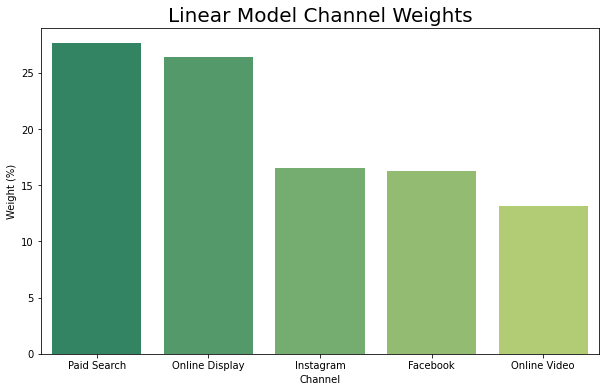

In [6]:
plt.subplots(figsize=(10, 6))
sns.barplot(data=linear, x=linear.index, y='Weight (%)')
plt.xlabel('Channel')
plt.title('Linear Model Channel Weights', fontsize=20)
plt.savefig('plots/linear.png')

From the linear model, we see that the leaders are Paid Search and Online Display. These results were au contraire to our single-touch models, where Facebook dominated, which demonstrates that we can't just rely on one model, since our results are dynamic.
## Position-Based (U-Shaped) Attribution Model
This model splits the credit for a sale between the first interaction and the moment it converts.
> 40% of the credit is given to each of these points, with the remaining 20% spread out between any other interactions that happened in the middle.

In [7]:
def calc_attribution_u(click_pos, total_clicks):
    """
    Helper function to calculate attributions
    """
    default_att = 0.5  # If a user has visited only two channels
    extreme_touch_att_1 = 0.4  # Assigning weight to first and last channels
    intermed_att_1 = 0.2  # Total weight for remaining channels
    
    if total_clicks == 2:
        return default_att
    elif total_clicks == 1:
        return 1
    else:
        if click_pos == total_clicks or click_pos == 1:
            return extreme_touch_att_1
        else:
            return intermed_att_1 / (total_clicks - 2)
        

def U_shaped_model(df, conv_col, channel_col, user_id):
    """
    Build a U-Shaped Multi-Touch Attribution Model
    """
    temp = df[df[conv_col] == 1]
    cookie_index = list(temp[user_id])
    df['new'] = df[user_id].isin(cookie_index)
    y = df['new'].isin([True])
    df_conv = df[y]
    
    count = Counter(df_conv[user_id])
    df_conv['clicks'] = df_conv[user_id].map(count)
    df_conv['click_pos'] = df_conv.groupby(user_id).cumcount() + 1
    df_U_shaped = df_conv
    df_U_shaped['U_shape'] = df_conv.apply(lambda x: round(
        calc_attribution_u(x['click_pos'], x['clicks']) * 100, 2), axis=1)
    
    # Get mean weight of every channel, don't return group names as index
    res_U_shaped = df_U_shaped.groupby(
        channel_col, as_index=False)['U_shape'].mean()
    _sum = res_U_shaped['U_shape'].sum()
    res_U_shaped['Weight (%)'] = res_U_shaped.apply(
        lambda x: round((x['U_shape'] / _sum) * 100, 2), axis=1)
    res_U_shaped.drop(['U_shape'], inplace=True, axis=1)
    res_U_shaped = res_U_shaped.set_index(channel_col)
    res_U_shaped.index.name = None
    return res_U_shaped.sort_values(by='Weight (%)', ascending=False)

U_shaped = U_shaped_model(df, 'conversion', 'channel', 'cookie')
U_shaped

,Weight (%)
Paid Search,27.48
Online Display,26.61
Instagram,16.65
Facebook,16.28
Online Video,12.99


In [8]:
U_shaped.to_csv('results/U_shaped.csv')

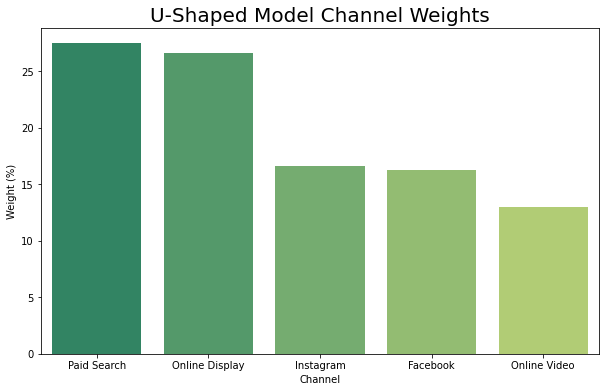

In [9]:
plt.subplots(figsize=(10, 6))
sns.barplot(data=U_shaped, x=U_shaped.index, y='Weight (%)')
plt.xlabel('Channel')
plt.title('U-Shaped Model Channel Weights', fontsize=20)
plt.savefig('plots/U_shaped.png')

Our U-Shaped Model results are nearly identical to those of our Linear Model.
## Position Decay Multi-Touch Attribution Model
This algorithm allocates points to all the channels used to conert, giving them credit in ascending order up to the last interaction. This modle assumes that a user's interest in a product grows with every interaction, and the last one is the most important as it determines whether a customer converts.

In [10]:
def calc_attribution_decay(click_pos, total_clicks):
    """
    Calculate attribution according to exponential decay of channel
    """
    rel_pos = total_clicks - click_pos
    attribution = pow(2, -rel_pos)  # Exponential decay
    return attribution


def pos_decay_model(df, conv_col, channel_col, user_id):
    """
    Build a Position Decay Multi-Touch Attribution Model
    """
    # Filter out non-converted users
    tmp = df[df[conv_col] == 1]
    cookie_index = list(tmp[user_id])
    df['new'] = df[user_id].isin(cookie_index)
    y = df['new'].isin([True])
    df_conv = df[y]
    
    count = Counter(df_conv[user_id])
    df_conv['clicks'] = df_conv[user_id].map(count)
    df_conv = df_conv.assign(
        clicks_per=lambda x: round(100 / df_conv['clicks'], 2))
    df_conv['click_pos'] = df_conv.groupby(user_id).cumcount() + 1
    df_conv['pos_decay'] = df_conv.apply(lambda x: round(
        calc_attribution_decay(
            x['click_pos'], x['clicks']) * 100, 2), axis=1)
    df_pos_decay = df_conv
    
    # Get mean weight of every channel, don't return group names as index
    res_pos_decay = df_pos_decay.groupby(
        'channel', as_index=False)['pos_decay'].mean()
    _sum = res_pos_decay['pos_decay'].sum()
    res_pos_decay['Weight (%)'] = res_pos_decay.apply(
        lambda x: round((x['pos_decay'] / _sum) * 100, 2), axis=1)
    res_pos_decay.drop(['pos_decay'], axis=1, inplace=True)
    res_pos_decay = res_pos_decay.set_index(channel_col)
    res_pos_decay.index.name = None
    return res_pos_decay.sort_values(by='Weight (%)', ascending=False)


pos_decay = pos_decay_model(df, 'conversion', 'channel', 'cookie')
pos_decay

,Weight (%)
Paid Search,25.64
Online Display,25.44
Instagram,17.14
Facebook,17.10
Online Video,14.68


In [11]:
pos_decay.to_csv('results/pos_decay.csv')

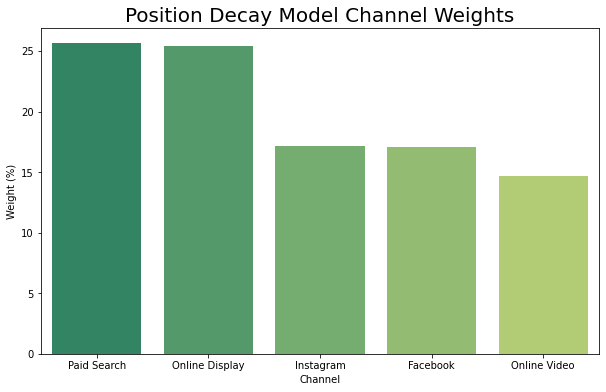

In [12]:
plt.subplots(figsize=(10, 6))
sns.barplot(data=pos_decay, x=pos_decay.index, y='Weight (%)')
plt.xlabel('Channel')
plt.title('Position Decay Model Channel Weights', fontsize=20)
plt.savefig('plots/pos_decay.png')

All of our multi-touch attribution models preached Paid Search and Online Display, unlike our single-touch models, which suggested that these channels don't perform as well. With these different results, we haven't yet reached our goals of optimizing our budget; which channels will drive the most revenue?